In [196]:
import numpy as np
from scipy.stats import norm, multivariate_normal, geom
import matplotlib.pyplot as plt

In [197]:
N_sample = 8
dim_x = 20
dim_z = 20
r = 0.6

def logmeanexp(data, axis=None):
    max_val = np.max(data, axis=axis)
    return max_val + np.log(np.mean(np.exp(data - max_val), axis=axis))

In [198]:
def p_theta_x(theta):
    mu = theta
    covariance = 2 * np.eye(dim_x)
    return multivariate_normal(mean=mu, cov=covariance)

In [199]:
theta_0 = norm.rvs(loc=0, scale=1)
print('theta_0 =', theta_0)
X = p_theta_x(np.zeros(dim_x) + theta_0).rvs()
print('X =', X)

theta_0 = -0.5574486645836989
X = [-0.37192115 -1.24516158 -0.76213376 -0.37960398 -2.87386555 -0.23504469
 -0.98298104 -3.06991218 -0.31199925  0.51329777 -0.54075659  0.21594483
 -2.26805325  0.61356536  0.48776673 -0.647982   -0.44079185 -0.28846252
 -0.52874733  0.78080019]


In [200]:
def q_phi_z_given_x(X):
    A = 1 / 2 * np.eye(dim_z, dim_x) #size = dim_z, dim_x
    b = np.zeros(dim_z) + np.mean(X) #size = dim_z, 1
    mu = A @ X + b
    covariance = 2 / 3 * np.eye(dim_z)
    return multivariate_normal(mean=mu, cov=covariance)

def generation_Z(X, size):
    Z = q_phi_z_given_x(X).rvs(size=size)
    Z_E, Z_O = Z[::2], Z[1::2]
    return Z, Z_E, Z_O

In [201]:
def p_theta_x_given_z(z):
    mu = z
    covariance = np.eye(dim_x)
    return multivariate_normal(mean=mu, cov=covariance)

def p_theta_z(theta):
    mu = np.zeros(dim_z) + theta
    covariance = np.eye(dim_z)
    return multivariate_normal(mean=mu, cov=covariance)

In [202]:
def estimateur_ml_ss(theta, X, N_sample):
    l_hat_ml_ss_lst = []
    for i in range(N_sample):
        K = geom.rvs(r)
        size = 2 ** (K + 1)
        Z, Z_E, Z_O = generation_Z(X, size)
        log_weights = [np.log(p_theta_z(theta).pdf(z) * p_theta_x_given_z(z).pdf(X) / q_phi_z_given_x(X).pdf(z)) for z in Z]
        log_weights_E, log_weights_O = log_weights[::2], log_weights[1::2]
        I_0 = np.mean(log_weights)
        l_hat_E, l_hat_O = logmeanexp(log_weights_E), logmeanexp(log_weights_O)
        l_hat_O_E = logmeanexp(log_weights)
        delta_K = l_hat_O_E - 0.5 * (l_hat_O + l_hat_E)
        l_hat_ml_ss_lst.append(I_0 + delta_K / geom(r).pmf(K))
    l_hat_ml_ss = np.mean(l_hat_ml_ss_lst)
    return l_hat_ml_ss

In [203]:
def estimateur_ml_rr(theta, X, N_sample):
    l_hat_ml_rr_lst = []
    for i in range(N_sample):
        K = geom.rvs(r)
        size = 2 ** (K + 1)
        Z, Z_E, Z_O = generation_Z(X, size)
        log_weights = [np.log(p_theta_z(theta).pdf(z) * p_theta_x_given_z(z).pdf(X) / q_phi_z_given_x(X).pdf(z)) for z in Z]
        log_weights_E, log_weights_O = log_weights[::2], log_weights[1::2]
        I_0 = np.mean(log_weights)
        l_hat_E, l_hat_O = logmeanexp(log_weights_E), logmeanexp(log_weights_O)
        l_hat_O_E = logmeanexp(log_weights)
        delta_k_list_rr = [logmeanexp(log_weights[:2**(k+1)]) - 0.5 * (logmeanexp(log_weights_O[:2**k]) + logmeanexp(log_weights_E[:2**k])) for k in range(K+1)]
        l_hat_ml_rr_lst.append(I_0 + np.sum([delta_k_list_rr[k] / (1 - geom(r).cdf(k-1)) for k in range(K+1)]))
    l_hat_ml_rr = np.mean(l_hat_ml_rr_lst)
    return l_hat_ml_rr

In [204]:
def estimateur_iwae(theta, X, N_sample):
    l_hat_iwae_lst = []
    for i in range(N_sample):
        K = geom.rvs(r)
        size = 2 ** (K + 1)
        Z, Z_E, Z_O = generation_Z(X, size)
        log_weights = [np.log(p_theta_z(theta).pdf(z) * p_theta_x_given_z(z).pdf(X) / q_phi_z_given_x(X).pdf(z)) for z in Z]
        l_hat_iwae_lst.append(logmeanexp(log_weights))
    l_hat_iwae = np.mean(l_hat_iwae_lst)
    return l_hat_iwae

In [205]:
def estimateur_sumo(theta, X, N_sample):
    l_hat_sumo_lst = []
    for i in range(N_sample):
        K = geom.rvs(r)
        size = 2 ** (K + 1)
        Z, Z_E, Z_O = generation_Z(X, size)
        log_weights = [np.log(p_theta_z(theta).pdf(z) * p_theta_x_given_z(z).pdf(X) / q_phi_z_given_x(X).pdf(z)) for z in Z]
        log_weights_E, log_weights_O = log_weights[::2], log_weights[1::2]
        I_0 = np.mean(log_weights)
        delta_k_list_sumo = [logmeanexp(log_weights[:2**(k+1)]) - logmeanexp(log_weights[:2**k]) for k in range(K+1)]
        l_hat_sumo_lst.append(I_0 + np.sum([delta_k_list_sumo[k] / (1 - geom(r).cdf(k-1)) for k in range(K+1)]))
    l_hat_sumo = np.mean(l_hat_sumo_lst)
    return l_hat_sumo

In [206]:
theta_lst = np.linspace(-3, 3, 100)

l_hat_ml_ss = [estimateur_ml_ss(theta, X, N_sample) for theta in theta_lst]
print('l_hat_ml_ss : ok')

l_hat_ml_rr = [estimateur_ml_rr(theta, X, N_sample) for theta in theta_lst]
print('l_hat_ml_rr : ok')

l_hat_iwae = [estimateur_iwae(theta, X, N_sample) for theta in theta_lst]
print('l_hat_iwae : ok')

l_hat_sumo = [estimateur_sumo(theta, X, N_sample) for theta in theta_lst]
print('l_hat_sumo : ok')

l_hat_ml_ss : ok
l_hat_ml_rr : ok
l_hat_iwae : ok
l_hat_sumo : ok


In [207]:
def true_likelihood(X, theta):
    l_true = 1
    for x in X:
        l_true *= norm.pdf(x, loc=theta, scale=2)
    return l_true


l_true = [np.log(true_likelihood(X, theta)) for theta in theta_lst]  

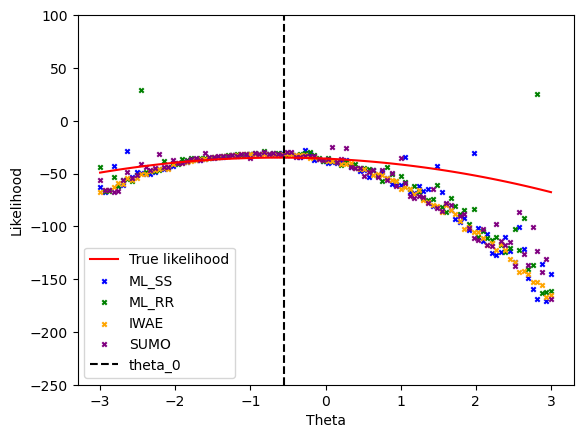

In [208]:
plt.plot(theta_lst, l_true, color='red', label='True likelihood')
plt.scatter(theta_lst, l_hat_ml_ss, color='blue', marker='x', label='ML_SS', s=10)
plt.scatter(theta_lst, l_hat_ml_rr, color='green', marker='x', label='ML_RR', s=10)
plt.scatter(theta_lst, l_hat_iwae, color='orange', marker='x', label='IWAE', s=10)
plt.scatter(theta_lst, l_hat_sumo, color='purple', marker='x', label='SUMO', s=10)
plt.axvline(x=theta_0, color='black', linestyle='--', label='theta_0')
plt.xlabel('Theta')
plt.ylabel('Likelihood')
plt.legend(loc='best')
plt.ylim(-250, 100)
plt.show()

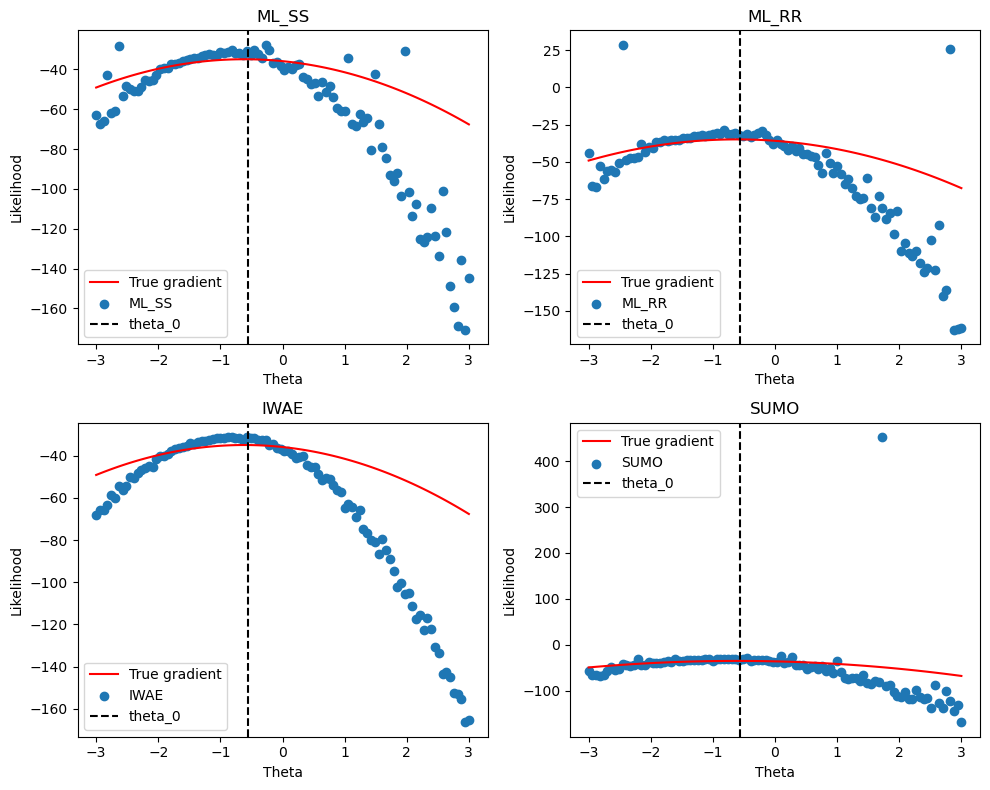

In [209]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

estimator_names = ['ML_SS', 'ML_RR', 'IWAE', 'SUMO']
estimators = [l_hat_ml_ss, l_hat_ml_rr, l_hat_iwae, l_hat_sumo]

for i, ax in enumerate(axs.flat):
    ax.plot(theta_lst, l_true, color='r', label='True gradient')
    ax.scatter(theta_lst, estimators[i], label=estimator_names[i])
    ax.axvline(x=theta_0, color='black', linestyle='--', label='theta_0')
    ax.set_xlabel('Theta')
    ax.set_ylabel('Likelihood')
    ax.legend(loc='best')
    ax.set_title(estimator_names[i])

plt.tight_layout()
plt.show()

In [210]:
theta_lst = np.linspace(-3, 3, 100)

l_grad_hat_ml_ss = np.gradient(l_hat_ml_ss)
l_grad_hat_ml_rr = np.gradient(l_hat_ml_rr)
l_grad_hat_iwae = np.gradient(l_hat_iwae)
l_grad_hat_sumo = np.gradient(l_hat_sumo)

In [211]:
def true_gradient(X, theta):
    return 1 /2 * (np.mean(X) - theta)

l_grad_true = [true_gradient(X, theta) for theta in theta_lst]

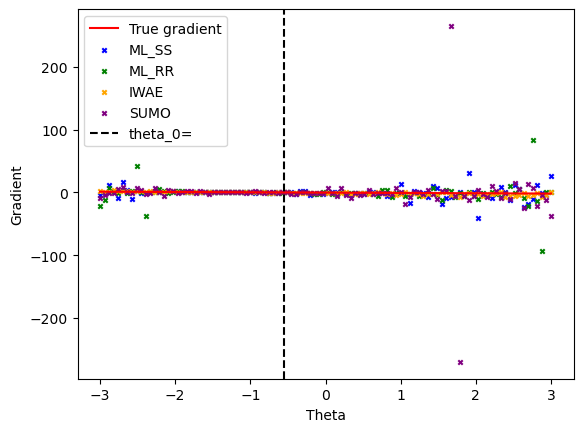

In [212]:
plt.plot(theta_lst, l_grad_true, color='r', label='True gradient')
plt.scatter(theta_lst, l_grad_hat_ml_ss, color='blue', marker='x', label='ML_SS', s=10)
plt.scatter(theta_lst, l_grad_hat_ml_rr, color='green', marker='x', label='ML_RR', s=10)
plt.scatter(theta_lst, l_grad_hat_iwae, color='orange', marker='x', label='IWAE', s=10)
plt.scatter(theta_lst, l_grad_hat_sumo, color='purple', marker='x', label='SUMO', s=10)
plt.axvline(x=theta_0, color='black', linestyle='--', label='theta_0=')
plt.xlabel('Theta')
plt.ylabel('Gradient')
plt.legend(loc='best')
plt.show()

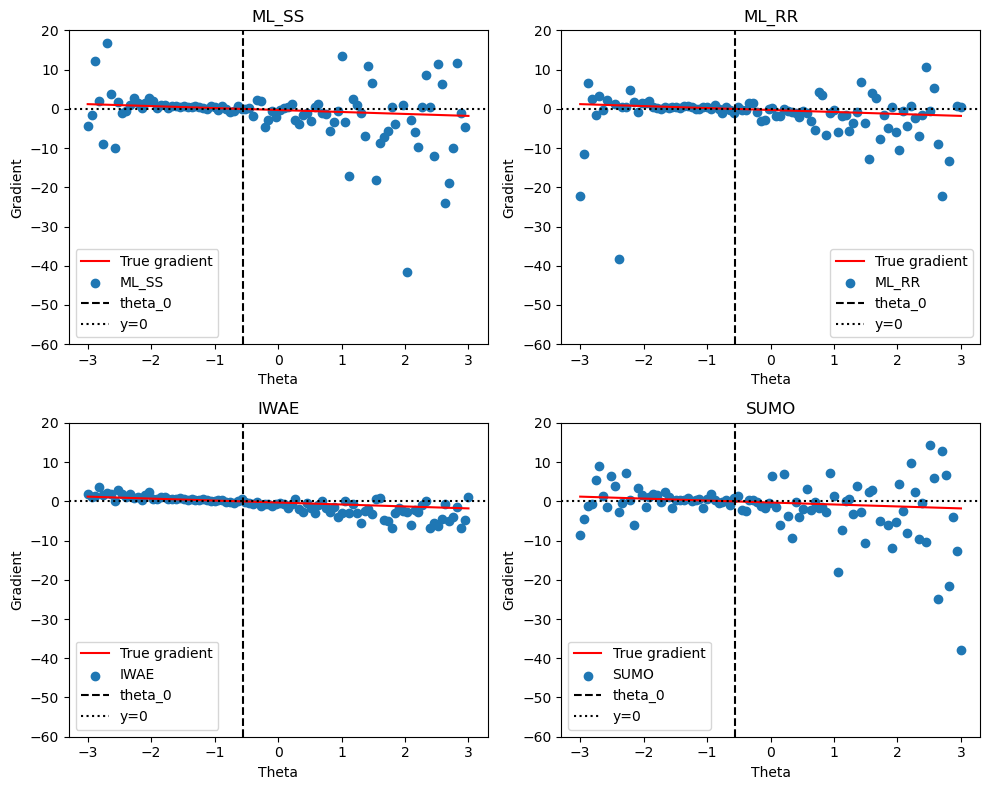

In [215]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

grad_estimators = [l_grad_hat_ml_ss, l_grad_hat_ml_rr, l_grad_hat_iwae, l_grad_hat_sumo]

for i, ax in enumerate(axs.flat):
    ax.plot(theta_lst, l_grad_true, color='r', label='True gradient')
    ax.scatter(theta_lst, grad_estimators[i], label=estimator_names[i])
    ax.axvline(x=theta_0, color='black', linestyle='--', label='theta_0')
    ax.axhline(y=0, color='black', linestyle=':', label='y=0')
    ax.set_xlabel('Theta')
    ax.set_ylabel('Gradient')
    ax.set_title(estimator_names[i])
    ax.legend(loc='best')
    ax.set_ylim(-60, 20)

plt.tight_layout()
plt.show()
